In [1]:
#jupyter notebook settings not a must but helps
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# helps in defining a model in sequential 
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# dealing with images 
from torchvision import datasets, transforms

# Aux Plotting function



In [2]:
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6
# for visualising samples, this helps to debug 

def view_classify(img, ps):  # ps is the list of probabilities

    ps = ps.data.numpy().squeeze() # convert to numpy array and remove the first dimension

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Load MNIST


In [12]:
# compose is like a pipleline, of the steps that we want to perform
# inituition is that transforms.ToTenso() converts the image to numpy then to tensor, PIL can be used to convert image to numpy array
# normalize is to normalize the image to be between 0 and 1
# transforms.Normalize((0.5), (0.5)) --> mean and std
# since data is grey scale we only need to specify the mean and std for the channel
#if we had colored then the function would be as transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the training data

trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform )

# we don't want to pass all that data once, cause memory lol
# rule of thumb : small batch size = smaller learning rate, bigger batch size = bigger learning rate
# in theory a big batch size makes trainig faster , the updates may to be big and this impacts the model 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)


# Download the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True) # shuffle is not necessary for test set, since we are not learning from it


In [13]:
# we can check the balance of the data 
import pandas as pd
pd.Series(trainset.targets.numpy()).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [14]:
pd.Series(testset.targets.numpy()).value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64

In [16]:
# accessing the data
for data,labels in trainloader:
    print(data.size(), labels.size())

torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size([16, 1, 28, 28]) torch.Size([16])
torch.Size

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

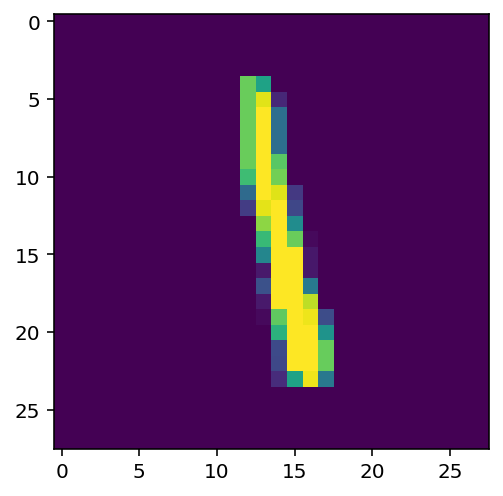

In [21]:
img = images[0]
#plt.imshow(img) #this wont directly work since we have a 3rd dimension of the image

# we can use .squeeze() to remove the dimension of the image
plt.imshow(img.squeeze())	

# Creating model



In [33]:
class Network(nn.Module):
    # what does nn.Module mean? well we are inheriting in the atrribute of nn.Module and methods of nn.Module
    # we then overwrite the constructor to define the network we want
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,128)  # input dim is 28x28 = 784 , value of output is defined by us, can be any number
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10) # the 10 has to be the number of classes, we have 10 classes in this case
        
    # Forward pass through the network, in order to ensure the manner in which the data is being passed through the network, returns the output logits
    # relu performs better than sigmoid as it does not make the values smaller going through the network and we may lose information
    def forward (self,x):
        x = x.view(x.shape[0],784)  # flatten the input, can be done here, or in training loop
        x = self.fc1(x)
        x = F.relu(x) # ReLU is a non-linearity function, it is a function that returns the max of the input and 0. 
            # here we are call it via F as it is a torch function, or you can define it in the method as we saw with sigmoid previously
        x = self.fc2(x)
        x = F.relu(x) #activation function decides whether the nueron fires or not, i.e. passing data through the network
        x = self.fc3(x)
        x = F.softmax(x, dim=1) # to get the probability of each class, dim =1 is the dimension we want to apply softmax on
        return x
    
model = Network()


# alternative manner is the sequential manner, your preference, sequential is more compact 
    

In [34]:
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [35]:
# if we just pass the images as we have load so far we will see a runtime error complaining that the images are not in the correct shape	
# mat1 --> (1, 28, 28) input to the model
# mat2 --> 784 gven by the weights of the first layer

# so we resize the images to the size of the first layer:
# main difference between resize and view is that resize is a function that changes the size of the image perma, view is a function that returns the image and does
# not change the size of the image
# prefer using the view 
# img.resize_(1,784)


# if we apply the model to the image, we get the output of the probabilities of each class, sum = 1
model(img.view(1, 784))
# we take the argmax of the output of the model, this is the predicted class


tensor([[0.1105, 0.1079, 0.0850, 0.1083, 0.0951, 0.0861, 0.0840, 0.1066, 0.1139,
         0.1025]], grad_fn=<SoftmaxBackward>)

In [36]:
criterion = nn.CrossEntropyLoss() # this is the loss function, we use cross entropy loss as we are using softmax, we can get away with/without softmax
optimizer = optim.Adam(model.parameters(), lr=0.001) #smaller lr takes longer to converge, adam is adaptive momentum optimizer

In [38]:
epochs = 1
for e in range(epochs):
    for i, (images, labels) in enumerate(iter(trainloader)):
        optimizer.zero_grad()  # to clean the gradient else it will accumulate the gradients
                                    # pytorch by default saves the gradients using the autograd,so it can do backpropagation quickly, but for each step we 
                                    # want fresh gradients for each iter, so we need to clean the gradients
        
        output = model.forward(images)
        loss = criterion(output, labels) 
        loss.backward()
        optimizer.step()
        

In [47]:
images, labels = next(dataiter)
t_img = images[7]
ps = model(t_img)

In [48]:
img.shape

torch.Size([1, 784])

In [49]:
ps

tensor([[1.4927e-19, 9.9976e-01, 3.9175e-05, 3.6160e-10, 6.7763e-10, 4.6642e-08,
         4.4660e-11, 1.9722e-04, 5.1449e-07, 2.2570e-12]],
       grad_fn=<SoftmaxBackward>)

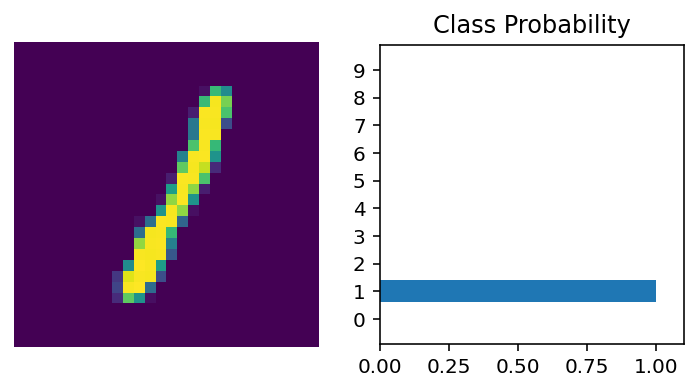

In [50]:
view_classify(t_img, ps)

In [ ]:
# training the model, you need to create this pretty much once adn you can use this over and over again the core is the 
# zero_grad() to the optimizer.step()
epochs = 3
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):    # tuple unpacking as we have both image and labels from the dataloader

        # Flatten MNIST images into a 784 long vector
        #images.resize_(images.size()[0], 784) no need since we defined it in the forward pass
        
        optimizer.zero_grad()       # to clean the gradient else it will accumulate the gradients
                                    # pytorch by default saves the gradients using the autograd,so it can do backpropagation quickly, but for each step we 
                                    # want fresh gradients for each iter, so we need to clean the gradients
        
        output = model.forward(images)   # 1) Forward pass   # you can also use model(images)
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0